In [1]:
import os
import cv2
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.cluster import KMeans
import joblib
from sklearn.metrics.pairwise import cosine_similarity

# 设置图像尺寸
w, h = 224, 224

# 加载预训练的 ResNet50 模型（不包含顶层的全连接层）
encoder = ResNet50(include_top=False)

# 加载保存的图片特征向量和聚类模型
with open('embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

kmeans = joblib.load('kmeans.pkl')

def extract_features(image_path):
    # 读取并预处理查询图片
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"无法读取图片：{image_path}")
    image = cv2.resize(image, (w, h))
    image = preprocess_input(image)
    # 提取特征
    features = encoder.predict(np.expand_dims(image, axis=0))
    # 将特征展平成一维向量
    features = tf.reshape(features, (-1,))
    return features

def retrieve_similar_images(query_image_path, embeddings, kmeans, top_k=5):
    # 提取查询图片的特征向量
    query_features = extract_features(query_image_path)
    query_features = query_features.numpy()  # 转换为 numpy 数组

    # 预测查询图片的聚类标签
    query_cluster = kmeans.predict([query_features])[0]

    # 收集同一聚类中的图片
    cluster_embeddings = [item for item in embeddings if item['cluster'] == query_cluster]

    # 如果同一聚类的图片数量不足，考虑从所有图片中检索
    if len(cluster_embeddings) < top_k:
        cluster_embeddings = embeddings

    # 计算相似度（余弦相似度）
    features_list = [item['embedding'].numpy() for item in cluster_embeddings]
    similarities = cosine_similarity([query_features], features_list)[0]

    # 将相似度和对应的图片路径结合
    results = list(zip(cluster_embeddings, similarities))
    # 按相似度从高到低排序
    results.sort(key=lambda x: x[1], reverse=True)

    # 获取最相似的 top_k 个图片
    top_results = results[:top_k]

    # 提取文件路径
    similar_images = [item[0]['filepath'] for item in top_results]
    
    return similar_images


2024-11-12 16:06:07.583653: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 16:06:07.596014: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731398767.610698    1970 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731398767.615029    1970 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 16:06:07.629585: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

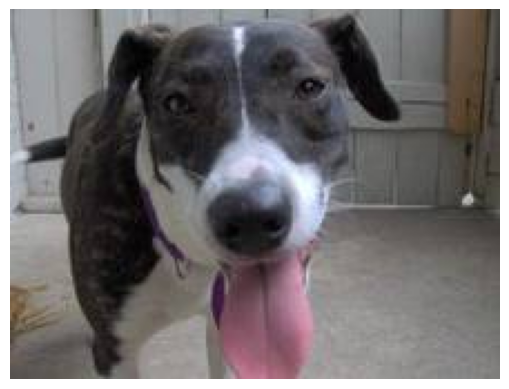

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
与查询图片相似的图片：
/mnt/workspace/datasets/dog.293.jpg
/mnt/workspace/datasets/dog.407.jpg
/mnt/workspace/datasets/dog.309.jpg
/mnt/workspace/datasets/dog.99.jpg
/mnt/workspace/datasets/dog.101.jpg


In [5]:
import matplotlib.pyplot as plt
query_image_path = '/mnt/workspace/test_image/dog.1003.jpg'  # 替换为您的查询图片路径
image_test = cv2.imread(query_image_path)
image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
plt.imshow(image_test)
plt.axis('off')
plt.show()
# 检索相似图片
similar_images = retrieve_similar_images(query_image_path, embeddings, kmeans, top_k=5)

# 输出或显示相似图片
print("与查询图片相似的图片：")
for img_path in similar_images:
    print(img_path)

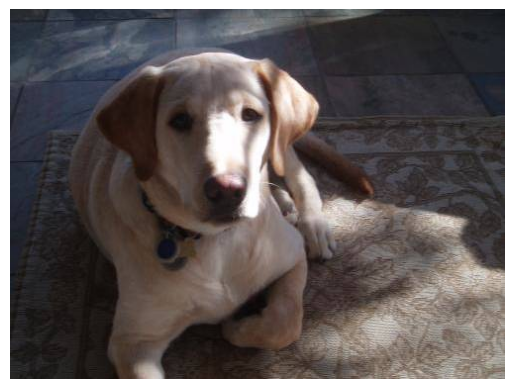

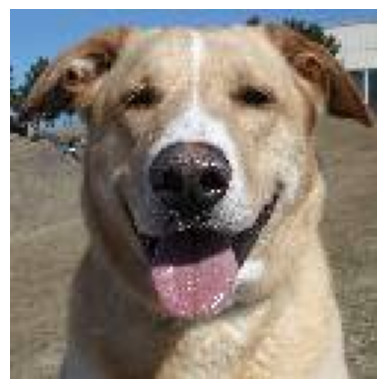

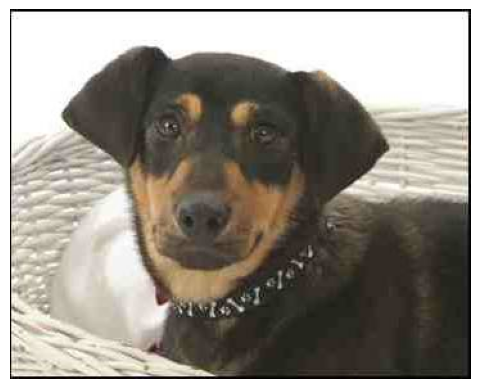

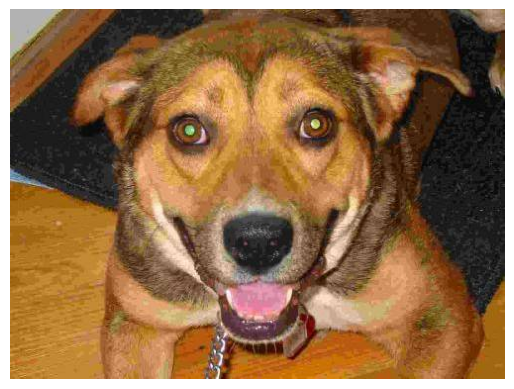

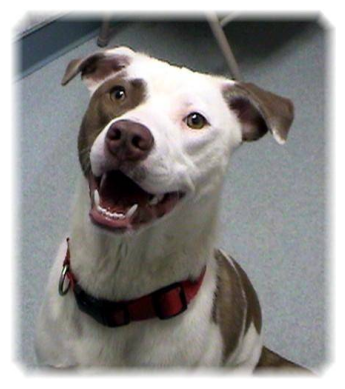

In [6]:
import matplotlib.pyplot as plt

for img_path in similar_images:
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
